<a href="https://colab.research.google.com/github/RamirezArizpe/Ciencia-de-datos-para-negocios/blob/UCA-Inteligencia-Artificial/Predicci%C3%B3n_precio_de_Bitcoin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Predecir el precio de Bitcoin's

#### Carga de datos

In [20]:
# Comenzamos la carga de la BDD, ésta proviene de un archivo alojado en gitbuh
import pandas as pd

_df = pd.read_csv("https://gist.githubusercontent.com/mevangelista-alvarado/6f4f28c00f9e683108637cb3c8d5db89/raw/1ce753283fce23eeab952fa1d660a7069bbe9104/Bitcoin_1_1_2024-6_9_2024_historical_data_coinmarketcap.csv", delimiter=';')
_df = _df.sort_index(ascending=False)
_df.head()

,timeOpen,timeClose,timeHigh,timeLow,name,open,high,low,close,volume,marketCap,timestamp
158,2024-01-03T00:00:00.000Z,2024-01-03T23:59:59.999Z,2024-01-03T09:40:00.000Z,2024-01-03T12:10:00.000Z,2781,44961.603187,45503.241795,40813.534868,42848.175641,4.634232e+10,8.393459e+11,2024-01-03T23:59:59.999Z
157,2024-01-04T00:00:00.000Z,2024-01-04T23:59:59.999Z,2024-01-04T22:22:00.000Z,2024-01-04T01:26:00.000Z,2781,42855.814761,44770.023414,42675.174007,44179.921701,3.044809e+10,8.654825e+11,2024-01-04T23:59:59.999Z
156,2024-01-05T00:00:00.000Z,2024-01-05T23:59:59.999Z,2024-01-05T23:07:00.000Z,2024-01-05T01:49:00.000Z,2781,44192.978699,44353.285859,42784.718266,44162.691630,3.233603e+10,8.651827e+11,2024-01-05T23:59:59.999Z
155,2024-01-06T00:00:00.000Z,2024-01-06T23:59:59.999Z,2024-01-06T00:10:00.000Z,2024-01-06T07:07:00.000Z,2781,44178.954607,44227.631307,43475.156431,43989.194093,1.609250e+10,8.618220e+11,2024-01-06T23:59:59.999Z
154,2024-01-07T00:00:00.000Z,2024-01-07T23:59:59.999Z,2024-01-07T14:09:00.000Z,2024-01-07T23:45:00.000Z,2781,43998.464243,44495.571471,43662.228627,43943.097229,1.933057e+10,8.609518e+11,2024-01-07T23:59:59.999Z


In [21]:
# el dataframe que obtendremos tiene una estructura predeterminada mostrada a continuación:
_df = _df[['timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name', 'open', 'high', 'low', 'close', 'volume', 'marketCap', 'timestamp']]

'timeOpen', 'timeClose', 'timeHigh', 'timeLow', 'name', 'open', 'high',
'low', 'close', 'volume', 'marketCap', 'timestamp'

('low', 'close', 'volume', 'marketCap', 'timestamp')

In [22]:
# Realizamos una selección de las variables de interés del dataframe original y procedemos a elaborar otro con un nombre nuevo
df = _df[['timeOpen', 'open', 'high', 'low', 'close']]

In [23]:
#convertimos los valores en un array
dates = df[['close']].values

#### Escalar los valores

In [24]:
# Aplicamos normalización de valores para quedarnos con datos entre 0 y 1, así el modelo puede ser entrenado con mayor fiabilidad y control

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dates)

#### Secuencias

In [25]:
# configuramos el tamaño de la ventana temporal que utilizará el modelo para su entrenamiento
window_size = 60
# es el número de puntos de datos que se utilizarán para predecir el siguiente punto de datos en una secuencia

In [26]:
# Aquí creamos las secuencias de datos que estaremos usando

import numpy as np

def create_sequences(data, window_size):
    sequences = []
    labels = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
        # La primer columna usada será el precio
        labels.append(data[i + window_size, 0])
    return np.array(sequences), np.array(labels)

X, y = create_sequences(scaled_data, window_size)

#### Conjunto de entrenamiento y prueba

In [27]:
# Dividimos los datos en entrenamiento (80%) y prueba (20%):
# 1) 'split' calcula el índice donde se separan los datos.
# 2) X_train e y_train contienen las primeras muestras (80%), usadas para entrenar el modelo.
# 3) X_test e y_test contienen las muestras restantes (20%), usadas para evaluar el modelo.
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Modelo RNNN
Para procesar secuencias de datos con una RNN simple y luego realizar una predicción utilizando capas conectadas completamente entre si.


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN

model = Sequential()
model.add(SimpleRNN(units=120, return_sequences=True, input_shape=(window_size, X_train.shape[2])))
model.add(SimpleRNN(units=60, return_sequences=False))
model.add(Dense(units=30))
model.add(Dense(units=1))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Entrenamiento y compilación

In [29]:
from tensorflow.keras.optimizers import Adam

learning_rate = 0.001
adam_optimizer = Adam(learning_rate=learning_rate)

# Compilar el modelo
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, batch_size=1, epochs=10)

Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.2297
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0307
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0249
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0089
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0104
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0064
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0092
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0047
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0067
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0080


In [30]:
#Vamos a hacer comprobaciones del modelo haciendo predicciones para ver el resultado
predictions = model.predict(X_test)

# Desescalar los datos predichos
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], 3))), axis=1))[:,0]
y_test = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 3))), axis=1))[:,0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step


#### Cálculo de métricas

In [31]:
# Calculamos las métricas de error del modelo:
# MAE (Mean Absolute Error): mide cuánto se equivoca el modelo en promedio,
#    tomando el valor absoluto de cada error. Entre más pequeño sea, mejor.
#
# RMSE (Root Mean Squared Error): mide el error promedio, pero penaliza más
#    los errores grandes, ya que eleva al cuadrado las diferencias antes de promediarlas.
#    Es más sensible a desviaciones fuertes. También: mientras más pequeño sea, mejor.
#
# Ambas métricas comparan las predicciones del modelo (predictions)
# contra los valores reales de prueba (y_test).
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MAE: 1576.7354480788526
RMSE: 1908.436301095266


#### Graficar resultados

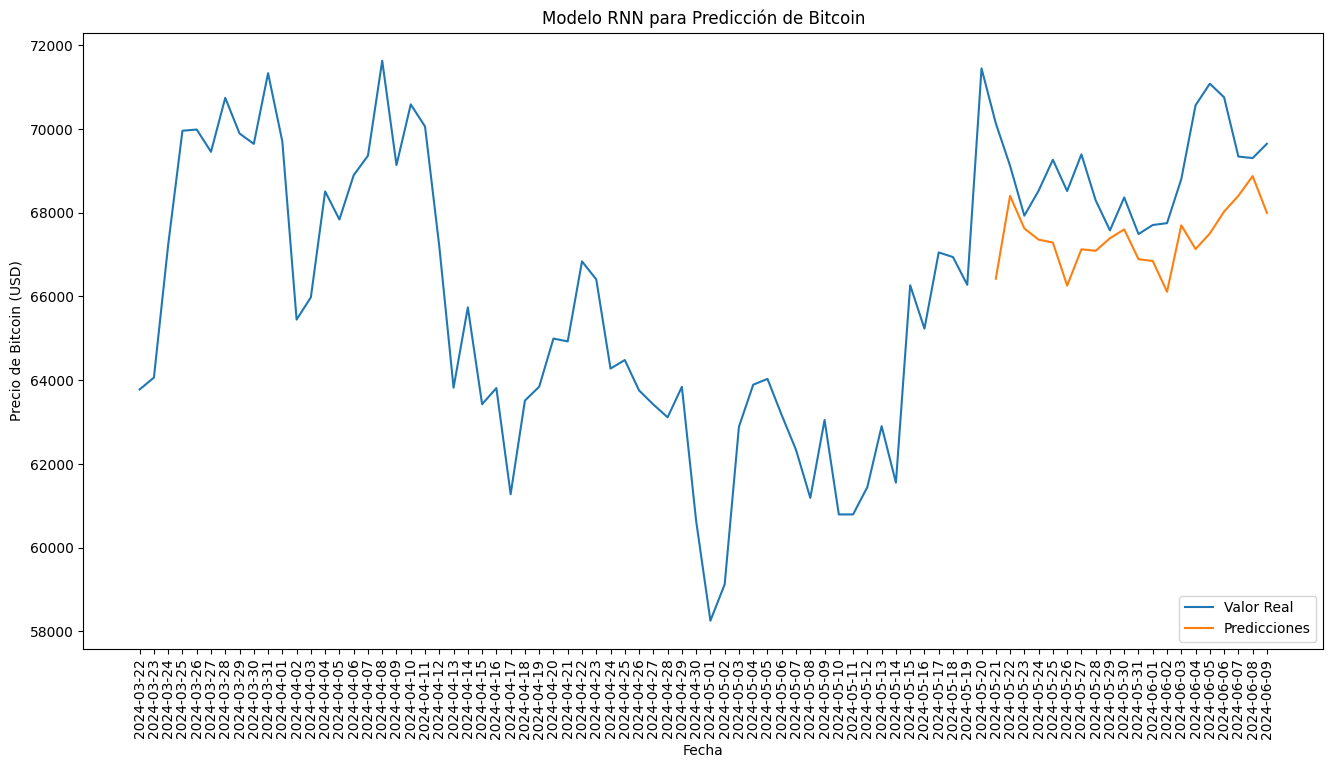

In [32]:
"""
Grafica los resultados de la predicción que hace la RNN en comparación a los datos de prueba
"""
import matplotlib.pyplot as plt
import numpy as np

valid = df[split:]
# Reiniciar el índice del DataFrame de validación
valid = valid.reset_index(drop=True)
# Inicializar la columna de predicciones con NaN
valid['Predictions'] = np.nan

# Añadir las predicciones al DataFrame de validación desde el punto donde inician las predicciones
valid.loc[window_size:, 'Predictions'] = predictions
dates_valid = pd.to_datetime(valid['timeOpen']).apply(lambda x: x.strftime('%Y-%m-%d')).tolist()

plt.figure(figsize=(16,8))
plt.title('Modelo RNN para Predicción de Bitcoin')
plt.xlabel('Fecha')
plt.ylabel('Precio de Bitcoin (USD)')
plt.plot(dates_valid, valid[['close', 'Predictions']])
plt.legend(['Valor Real', 'Predicciones'], loc='lower right')
plt.xticks(rotation=90)
plt.show()

Predicción de valores nuevos

In [33]:
# Generamos predicciones del valor de cierre de Bitcoin para los próximos días.
# Aquí utilizamos un método de predicción autoregresiva:
# usamos la última ventana de datos disponible, predecimos 1 día, lo añadimos a la ventana
# y la ventana se desliza para predecir el siguiente día, y así sucesivamente.

future_sequences = []

# Recuperamos la última secuencia (últimos 'window_size' valores) usada por el modelo.
last_sequence = X[-1]

days = 10   # Número de días futuros a predecir

for _ in range(days):
    # 1) Predecimos el siguiente valor con el modelo usando la última secuencia.
    next_value = model.predict(np.array([last_sequence]))[0, 0]

    # 2) Actualizamos la secuencia desplazándola una posición hacia la izquierda
    #    y agregando al final el valor recién predicho.
    last_sequence = np.concatenate((last_sequence[1:], [[next_value]]), axis=0)

    # 3) Guardamos la nueva secuencia para usarla en las predicciones finales.
    future_sequences.append(last_sequence)

# Convertimos la lista de secuencias futuras en un arreglo numpy y lo reacomodamos
# para cumplir con la forma que requiere una RNN (samples, timesteps, features).
future_sequences = np.array(future_sequences)
future_sequences = np.reshape(
    future_sequences,
    (future_sequences.shape[0], future_sequences.shape[1], 1)
)

# Predicción final del modelo sobre cada secuencia futura.
future_predictions = model.predict(future_sequences)

# Desescalamos los valores predichos para regresar al valor real de cierre (precio original).
# El scaler se entrenó con 4 variables, así que reconstruimos un vector de 4 columnas:
# la 1a columna es la predicción y las otras 3 son ceros (solo para permitir el inverse_transform).
future_predictions = scaler.inverse_transform(
    np.concatenate(
        (future_predictions, np.zeros((future_predictions.shape[0], 3))),
        axis=1
    )
)[:, 0]  # Nos quedamos únicamente con la columna del precio predicho


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step


In [34]:
"""
Generamos las fechas correspondientes a las predicciones futuras.
Esto sirve para alinear cada valor predicho con una fecha en el calendario.

Pasos:
1) Tomamos la última fecha disponible en los datos reales.
2) Creamos un rango de fechas futuras usando la cantidad de días a predecir.
3) Eliminamos la primera fecha (que sería la misma que la última real)
   y nos quedamos solo con las fechas nuevas.
4) Convertimos las fechas al formato 'YYYY-MM-DD' para facilidad de graficación y lectura.
"""

# Última fecha registrada en el dataset
last_date = df['timeOpen'].iloc[-1]

# Creamos un rango de fechas que cubra el número de días a predecir
future_dates = pd.date_range(start=last_date, periods=days)[1:]

# Convertimos a lista de strings con formato estándar
future_dates = future_dates.strftime('%Y-%m-%d').tolist()


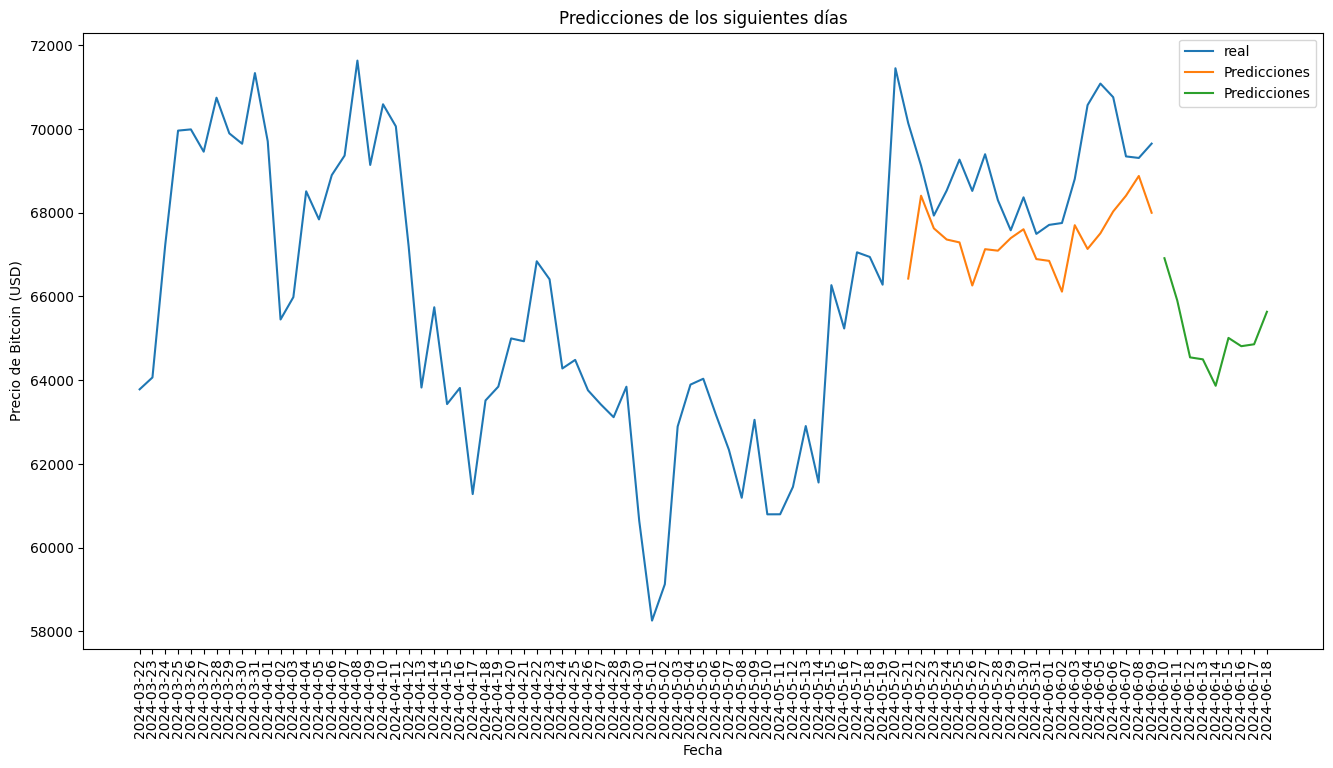

In [35]:
"""
Graficar los resultados de la predicción de los siguientes días
"""
plt.figure(figsize=(16,8))
plt.title('Predicciones de los siguientes días')
plt.xlabel('Fecha')
plt.ylabel('Precio de Bitcoin (USD)')
plt.plot(dates_valid, valid[['close', 'Predictions']], label=['real', 'Predicciones'])
plt.plot(future_dates, future_predictions[:-1], label='Predicciones')
plt.legend()
plt.xticks(rotation=90)
plt.show()

# Conclusiones

El desarrollo de una Red Neuronal Recurrente (RNN) para predecir el precio de cierre de Bitcoin constituye un ejercicio valioso para comprender cómo el aprendizaje automático puede aplicarse al análisis financiero y, en particular, a la modelación de series temporales con alta volatilidad. Este proyecto permitió explorar, de manera práctica, el proceso completo: desde la preparación de datos hasta la evaluación y generación de predicciones futuras.

En primer lugar, la fase de preprocesamiento resultó fundamental. La normalización de los valores y la construcción de secuencias de 60 días proporcionaron al modelo un contexto temporal adecuado para aprender patrones recurrentes en el comportamiento del precio. Esta estrategia permitió que la RNN capturara tendencias y dinámicas relevantes dentro de los datos históricos.

En cuanto al modelo, la arquitectura basada en RNN demostró ser capaz de identificar relaciones temporales, aunque sus predicciones reflejan las limitaciones inherentes a un problema tan complejo como la predicción del valor de Bitcoin. El desempeño del modelo —medido mediante el Error Absoluto Medio (MAE ≈ 815.82) y la Raíz del Error Cuadrático Medio (RMSE ≈ 1,092.66)— indica que, si bien logra aproximarse a la tendencia general, presenta desviaciones significativas en términos absolutos debido a la magnitud y volatilidad del activo.

Los resultados finales muestran que la RNN consigue seguir parcialmente la tendencia global del precio, aunque las predicciones no alcanzan precisión suficiente para ser utilizadas como herramienta principal de inversión. No obstante, este tipo de modelos puede servir como complemento analítico dentro de un enfoque más amplio que considere indicadores técnicos, análisis fundamental, condiciones macroeconómicas y la naturaleza especulativa del mercado de criptomonedas.

En síntesis, el ejercicio demuestra que las RNN pueden aportar valor en la exploración y comprensión de patrones en series temporales financieras, pero también confirma que ningún modelo predictivo es completamente fiable en mercados altamente volátiles. Las predicciones deben interpretarse con cautela y siempre acompañarse de otros métodos de análisis y gestión de riesgo.